# GEMPIC

### Geometric ElectroMagnetic Particle-In-Cell Methods

https://arxiv.org/abs/1609.03053

Michael Kraus, Katharina Kormann, Philip J. Morrison, Eric Sonnendrücker

Framework for Finite Element Particle-in-Cell methods based on
the discretization of the underlying Hamiltonian structure of the
Vlasov-Maxwell system.

Install the GEMPIC package

In [1]:
using Pkg

Pkg.add(PackageSpec(url="https://github.com/juliavlasov/GEMPIC.jl"))

using ProgressMeter, Plots, GEMPIC

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
  Updating git-repo `https://github.com/juliavlasov/GEMPIC.jl`
  Updating git-repo `https://github.com/juliavlasov/GEMPIC.jl`
 Resolving package versions...
  Updating `~/Numkin2019/Project.toml`
 [no changes]
  Updating `~/Numkin2019/Manifest.toml`
 [no changes]


# Strong Landau Damping

The physical parameters

In [2]:
kx, α = 0.5, 0.5
xmin, xmax = 0, 2π/kx
domain = [xmin, xmax, xmax - xmin]

3-element Array{Float64,1}:
  0.0              
 12.566370614359172
 12.566370614359172

The numerical parameters

In [3]:
∆t = 0.05
nx = 32
n_particles = 100000
mesh = GEMPIC.Mesh( xmin, xmax, nx)
spline_degree = 3

3

Initialize particles

In [4]:
mass, charge = 1.0, 1.0
particle_group = GEMPIC.ParticleGroup{1,2}( n_particles, mass, charge, 1)
sampler = LandauDamping( α, kx)

sample!(sampler, particle_group)

Particle-mesh coupling operators

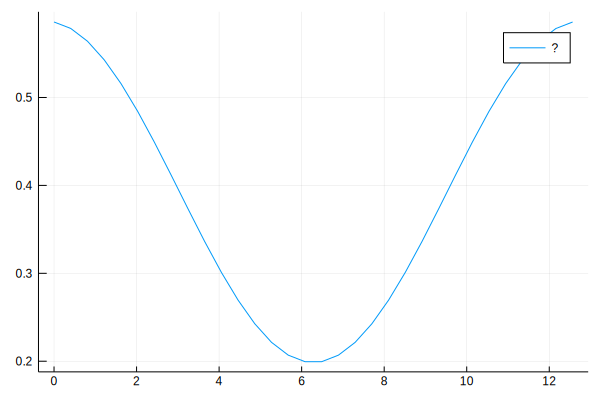

In [5]:
kernel_smoother1 = ParticleMeshCoupling( domain, [nx], n_particles,
                                         spline_degree-1, :galerkin)

kernel_smoother0 = ParticleMeshCoupling( domain, [nx], n_particles,
                                         spline_degree, :galerkin)
# Allocate electrostatic fields and Maxwell solver
rho = zeros(Float64, nx)
efield_poisson = zeros(Float64, nx)

maxwell_solver = Maxwell1DFEM(domain, nx, spline_degree)

solve_poisson!( efield_poisson, particle_group,
                kernel_smoother0, maxwell_solver, rho)
# ### Charge density
xg = LinRange(xmin, xmax, nx)
sval = eval_uniform_periodic_spline_curve(spline_degree-1, rho)
plot( xg, sval, label="ρ")

### Electric field

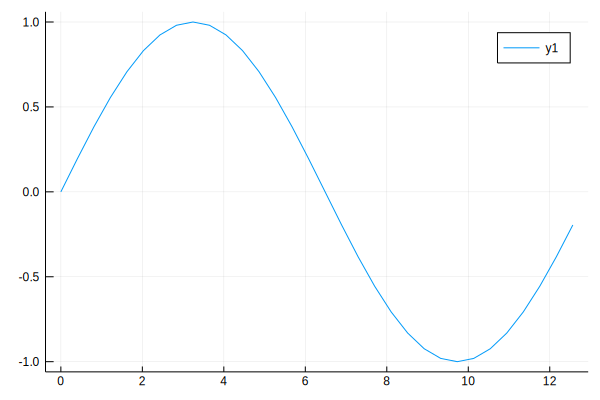

In [6]:
sval = eval_uniform_periodic_spline_curve(spline_degree-1, efield_poisson)
plot( xg, sval )

Initialize the arrays for the spline coefficients of the fields

In [7]:
efield_dofs = [copy(efield_poisson), zeros(Float64, nx)]
bfield_dofs = zeros(Float64, nx)

propagator = HamiltonianSplitting( maxwell_solver,
                                   kernel_smoother0,
                                   kernel_smoother1,
                                   particle_group,
                                   efield_dofs,
                                   bfield_dofs,
                                   domain);

efield_dofs_n = propagator.e_dofs

thdiag = TimeHistoryDiagnostics( particle_group, maxwell_solver,
                        kernel_smoother0, kernel_smoother1 );
# ## Loop over time
steps, Δt = 100, 0.05

@showprogress 1 for j = 1:steps # loop over time

    # Strang splitting
    strang_splitting!(propagator, Δt, 1)

    # Diagnostics
    solve_poisson!( efield_poisson, particle_group,
                    kernel_smoother0, maxwell_solver, rho)

    write_step!(thdiag, j * Δt, spline_degree,
                    efield_dofs,  bfield_dofs,
                    efield_dofs_n, efield_poisson)

end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


## Diagnostics stored in a dataframe

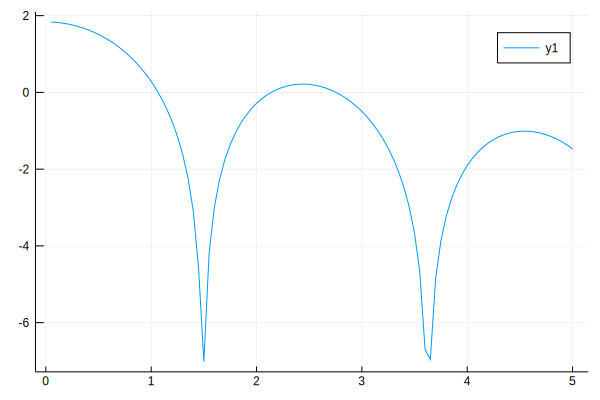

In [8]:
using DataFrames
first(thdiag.data, 5)


plot(thdiag.data[!,:Time], log.(thdiag.data[!,:PotentialEnergyE1]))

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*